In [69]:
import json

import pandas as pd
import geopandas as gpd
import fiona
import altair as alt
from vega_datasets import data
import folium

In [2]:
fname = "../data/_Onefootball_3_1_Exozet.gpx"

# Parse GPX data

In [3]:
fiona.listlayers(fname)

['waypoints', 'routes', 'tracks', 'route_points', 'track_points']

In [221]:
# https://geopandas.org/io.html#reading-spatial-data
gdf = (
    gpd.read_file(
        fname, layer="track_points"
    )[['track_seg_point_id', 'ele', 'time', 'geometry']]
    .rename(columns=dict(track_seg_point_id="id"))
    .set_index("id")
)
gdf["times"] = pd.to_datetime(gdf.time, format='%Y-%m-%dT%H:%M:%S').values.astype('int64') // 10 ** 6
gdf.times = gdf.times.apply(lambda x: [x])
gdf = gdf.drop("time", axis=1)
gdf.dtypes

ele          float64
geometry    geometry
times         object
dtype: object

In [199]:
gdf_linestring = gpd.read_file(fname, layer="tracks")[['name', 'geometry']]

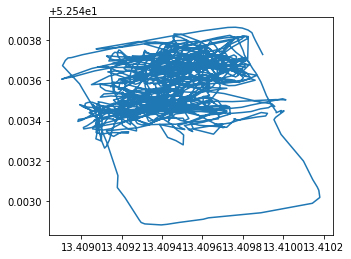

In [201]:
gdf_linestring.plot()

In [190]:
gpd.read_file(fname, layer="tracks").geometry

0    MULTILINESTRING ((13.40990 52.54372, 13.40990 ...
Name: geometry, dtype: geometry

In [186]:
gdf.head()

,ele,geometry,times
id,,,
0,83.2,POINT (13.40990 52.54372),[1583776677000]
1,83.2,POINT (13.40990 52.54372),[1583776678000]
2,83.2,POINT (13.40986 52.54380),[1583776684000]
3,83.2,POINT (13.40985 52.54382),[1583776685000]
4,83.2,POINT (13.40985 52.54384),[1583776686000]


# Altair Geoshape plot

Altair recipe:
- alt.Chart() => dataframe
- .mark_xx() => the kind of chart point
- .encode() => how to encode the data in the df for the chart
- .properties().interactive() => other properties, independent of data

In [173]:
(
    alt
    .Chart(gdf)
    .mark_geoshape(
        stroke='white'
    )
    .encode(
        color=alt.Color('ele'),
    )
    .properties(
        width=600,
        height=500
    )
)

alt.Chart(...)

**Note**: Altair doesn't support adding a basemap to a plot (because Vega-lite doesn't support it)

# Adding a basemap 

In [174]:
max_zoom = 18
centroid = gpd.read_file(fname, layer="tracks").centroid
# (gdf.geometry.y.mean(), gdf.geometry.x.mean())
m = folium.Map(
    location=[centroid.y, centroid.x], 
    zoom_start=max_zoom,
   zoom_control=False,
   scrollWheelZoom=False,
   dragging=False
)
m

**Note**: Adding the geoJSON data in folium is super slow and non informative as it shows every point with a marker :/ 
```python
folium.GeoJson(gdf.drop('time', axis=1).sample(100)).add_to(m)
```

# Time Series geo JSON

In [177]:
from folium.plugins import TimestampedGeoJson

In [230]:
# https://python-visualization.github.io/folium/plugins.html#folium.plugins.TimestampedGeoJson
m = folium.Map(
    location=[gdf_linestring.centroid.y, gdf_linestring.centroid.x], 
    zoom_start=max_zoom,
   zoom_control=False,
   scrollWheelZoom=False,
   dragging=False
)
TimestampedGeoJson(
    data=gdf.to_json(),
    transition_time=100,
    period='PT5S',
    duration='PT20S',
    loop=False,
    auto_play=False,
    loop_button=True
).add_to(m)
m.save('../data/timestamped_geojson_onefootball_game.html')
m